# Import Libararies

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install tensorflow
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image_dataset_from_directory
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import MaxPooling2D
from keras.layers import Conv2DTranspose, Concatenate
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, Lambda
from keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, Flatten,GlobalMaxPooling2D,GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import os
from tensorflow.keras.layers import Dense, BatchNormalization, Input, Dropout
from tensorflow.keras import layers


In [3]:
import seaborn as sns
import pandas as pd
from collections import defaultdict

In [4]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   108M      0  0:00:07  0:00:07 --:--:--  112M


In [5]:
!unzip -q kagglecatsanddogs_5340.zip
!ls -Rd PetImages/*

PetImages/Cat  PetImages/Dog


In [6]:
# Delete Corrupted Images

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


# Explore Dataset and showing the images for each class

In [7]:
BATCH_SIZE=64
IMG_SIZE=224
SEED=42

In [8]:
# Training & Validation
pet_train, pet_val = image_dataset_from_directory('PetImages',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(224,224),
                                                validation_split=0.2,
                                                subset="both")

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


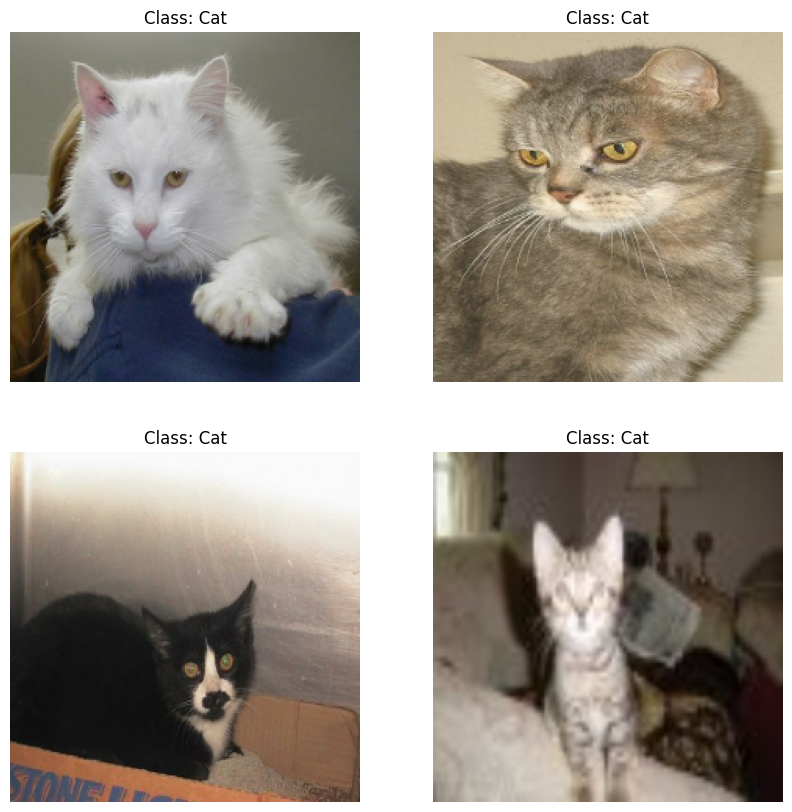

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in pet_train.take(2):
  for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(np.array(images[i]).astype('uint8'))
    plt.title(f'Class: {["Cat", "Dog"][labels[i]]}')
    plt.axis('off')

#### EXPLORE CLASS

In [10]:
class_names = pet_train.class_names
print(class_names)

['Cat', 'Dog']


In [11]:
counts_of_each_class = {}
for images, labels in pet_train:
    for label in labels.numpy():
        class_name = class_names[label]
        if class_name in counts_of_each_class:
            counts_of_each_class[class_name] += 1
        else:
            counts_of_each_class[class_name] = 1


print(counts_of_each_class)

{'Dog': 9297, 'Cat': 9431}


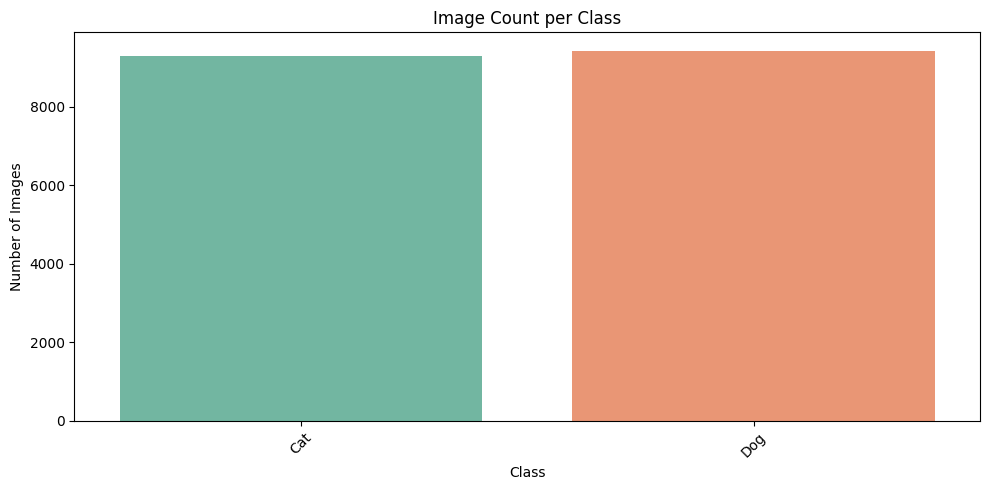

In [12]:
# sns.color_palette("tab10")
plt.figure(figsize=(10, 5))
sns.barplot(x=class_names, y=counts_of_each_class.values(),palette="Set2")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Image Count per Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### What's the number of images in the dataset?

In [13]:
print(f"number of images in train dataset: {len(pet_train)}")
print(f"number of images in validation dataset: {len(pet_val)}")

number of images in train dataset: 293
number of images in validation dataset: 74


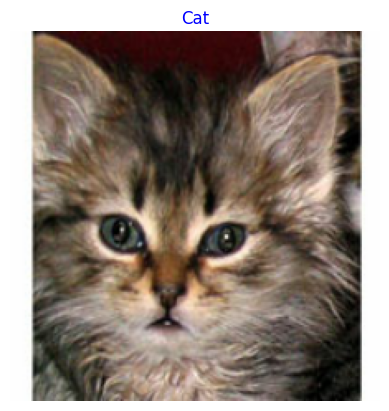

Image shape: (224, 224, 3)


In [18]:
img = pet_train.take(1)
img_batch, label_batch = next(iter(img))

label = label_batch[0].numpy()
class_name = class_names[label]

plt.imshow(img_batch[0].numpy().astype('uint8'))
plt.title(f"{class_name}", color='blue')
plt.axis("off")
plt.show()

print(f"Image shape: {img_batch[0].shape}")


# Modeling

Use EfficientNetB0 model

In [19]:

num_classes = len(class_names)

base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = tf.keras.applications.efficientnet.preprocess_input(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)


x = layers.Dropout(0.2)(x)


outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [20]:
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),

    loss='binary_crossentropy',
    metrics=['accuracy']
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras", save_best_only=True, monitor='val_accuracy'
)
earlystop_cb = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True
)

reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

In [22]:
epochs = 5
history = model.fit(
    pet_train,
    validation_data=pet_val,
    epochs=epochs,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

Epoch 1/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 83s 284ms/step - accuracy: 0.9629 - loss: 0.1584 - val_accuracy: 0.9836 - val_loss: 0.0680 - learning_rate: 1.0000e-05
Epoch 2/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 78s 267ms/step - accuracy: 0.9749 - loss: 0.0898 - val_accuracy: 0.9872 - val_loss: 0.0437 - learning_rate: 1.0000e-05
Epoch 3/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 82s 269ms/step - accuracy: 0.9797 - loss: 0.0645 - val_accuracy: 0.9893 - val_loss: 0.0333 - learning_rate: 1.0000e-05
Epoch 4/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 78s 265ms/step - accuracy: 0.9850 - loss: 0.0463 - val_accuracy: 0.9915 - val_loss: 0.0271 - learning_rate: 1.0000e-05
Epoch 5/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 83s 267ms/step - accuracy: 0.9888 - loss: 0.0363 - val_accuracy: 0.9919 - val_loss: 0.0234 - learning_rate: 1.0000e-05


#### Evaluation

In [23]:
loss,acc_train=model.evaluate(pet_train)
print(f"Accuracy training: {acc_train}")

loss,acc_val=model.evaluate(pet_train)
print(f"Accuracy validation: {acc_val}")

293/293 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - accuracy: 0.9955 - loss: 0.0188
Accuracy training: 0.9961020946502686
293/293 ━━━━━━━━━━━━━━━━━━━━ 24s 82ms/step - accuracy: 0.9954 - loss: 0.0190
Accuracy validation: 0.9961020946502686


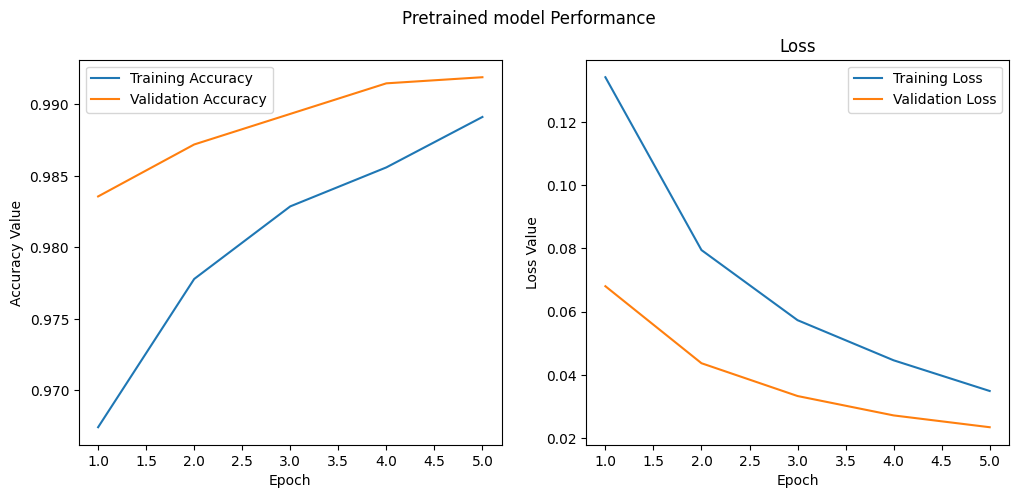

In [24]:
epochs = range(1, len(history.history['accuracy']) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(epochs, history.history['accuracy'], label='Training Accuracy')
ax[0].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy Value')
ax[0].legend()



ax[1].plot(epochs,history.history['loss'], label='Training Loss')
ax[1].plot(epochs, history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss Value')
ax[1].legend()

fig.suptitle('Pretrained model Performance')

plt.show();

### Predication

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


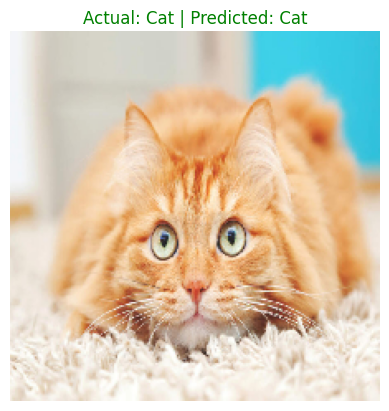

In [30]:
img_path = "/content/Cat_image1.jpg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array_expanded = tf.expand_dims(img_array, 0)

# Predict
predictions = model.predict(img_array_expanded)


predicted_class_index = 1 if predictions[0][0] > 0.5 else 0
predicted_class = class_names[predicted_class_index]

actual_class = 'Cat'

plt.imshow(img_array.astype("uint8"))
plt.title(f"Actual: {actual_class} | Predicted: {predicted_class}", color="green")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


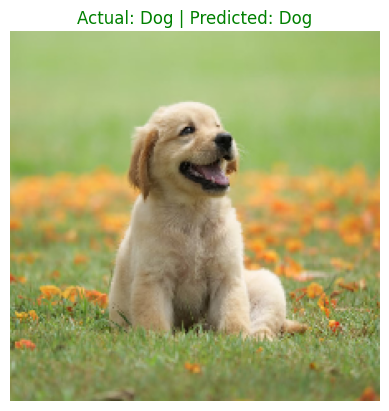

In [31]:
img_path = "/content/Dog_image1.jpg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array_expanded = tf.expand_dims(img_array, 0)

# Predict
predictions = model.predict(img_array_expanded)


predicted_class_index = 1 if predictions[0][0] > 0.5 else 0
predicted_class = class_names[predicted_class_index]

actual_class = 'Dog'

plt.imshow(img_array.astype("uint8"))
plt.title(f"Actual: {actual_class} | Predicted: {predicted_class}", color="green")
plt.axis("off")
plt.show()

### Save model

In [34]:
# Save model
model.save("my_pet_model.h5")

In [35]:
# Save model
model.save("my_pet_model.keras")